# Time Series Trove - Signal Analysis

Signal analysis is a subtype of time series analysis that focuses on understanding and analyzing continuous, high-frequency physical signals, usually originating from sensors or other measurement devices. Unlike traditional time series data, which may be collected at regular intervals (e.g., daily stock prices, monthly sales figures), signal data is often sampled at much higher frequencies (e.g., milliseconds, microseconds) and can exhibit complex patterns, noise, and variability.

As such, signal analysis often requires specialized techniques and tools to effectively process, analyze, and interpret the data. Common techniques used in signal analysis include Fourier transforms, wavelet transforms, filtering, and spectral analysis. These methods help to identify underlying patterns, trends, and anomalies in the signal data, which can be crucial for applications such as fault detection, predictive maintenance, and quality control.

1. [Data Loading and Preprocessing](#Data-Loading-and-Preprocessing)
2. [Defining Some Terms](#Defining-Some-Terms)
3. [Fourier Transforms + Spectral Analysis](#Fourier-Transforms-+-Spectral-Analysis)
4. [Filtering Techniques](#Filtering-Techniques)
5. [Wavelet Transforms](#Wavelet-Transforms)

> This notebook is a little different from the others in this repo, as it focuses on signal analysis techniques rather than traditional time series forecasting or anomaly detection. The techniques discussed here are particularly relevant for high-frequency sensor data and other continuous signals, which may not fit neatly into the standard time series framework. It also affects the tools used - the EDA will be different, and the charts will be graphed with matplotlib instead of plotly prevent memory issues as we are working with high-frequency data with potentially millions of data points.

In [1]:
import pandas as pd
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Data Loading and Preprocessing

In [2]:
from scipy.io import loadmat

path = pathlib.Path("../data/anomaly_detection/cwru-mat-full-dataset/")

cwru_normals = ['97.mat', '98.mat', '99.mat', '100.mat']
cwru_faults = ['190.mat', '191.mat', '192.mat', '193.mat']

def load_mat_ts_data(file_path: pathlib.Path, key_suffix: str):
    mat_file = loadmat(file_path)
    mat_keys = [k for k in mat_file.keys() if k.endswith(key_suffix)]
    if not mat_keys:
        raise KeyError(f"No key ending with '{key_suffix}' found in the .mat file.")
    key = mat_keys[0]
    ts = mat_file[key]
    return ts.flatten()

In [3]:
ts_normal = load_mat_ts_data(path / cwru_normals[0], '_DE_time')
ts_fault = load_mat_ts_data(path / cwru_faults[0], '_DE_time')

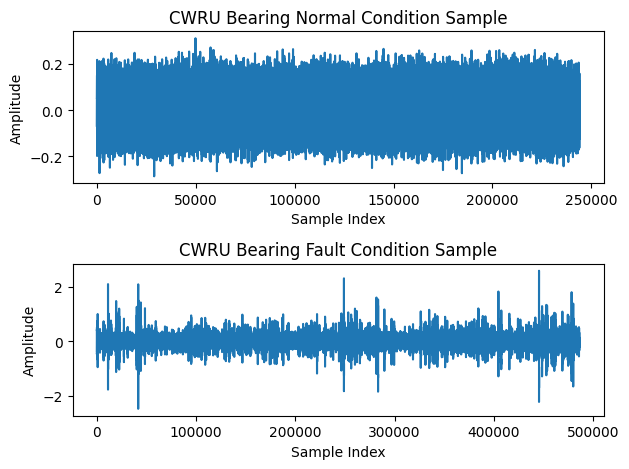

In [4]:
plt.subplot(2, 1, 1)
plt.plot(ts_normal)
plt.title("CWRU Bearing Normal Condition Sample")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude") 
plt.subplot(2, 1, 2)
plt.plot(ts_fault)
plt.title("CWRU Bearing Fault Condition Sample")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.tight_layout()

# Defining Some Terms

Signal analysis introduces several specialized concepts and terms that are important to understand before we look at any actual data.

- **Sampling Rate**: The frequency at which a continuous signal is sampled to create a discrete representation. It is typically measured in samples per second (Hz).
- **Periodic Signals**: Signals that repeat at regular intervals over time, wherein a full repetition is called a cycle and the duration of one cycle is the period.
- **Frequency**: The number of cycles a periodic signal completes in one second, measured in Hertz (Hz). It is the inverse of the period.
- **Waveform**: The shape of the signal when plotted over time, which can take various forms such as sine waves, square waves, or complex waveforms.
- **Nyquist Limit**: The highest frequency that can be accurately represented when sampling a continuous signal, equal to half the sampling rate. If you are measuring a signal every second (1 Hz), the highest frequency you can accurately capture is 0.5 Hz.
- **Aliasing**: A phenomenon that occurs when a signal is sampled at a rate lower than the Nyquist limit, causing higher frequency components to be misrepresented as lower frequency components in the sampled data.
- **Amplitude**: The height of the waveform, representing the signal's strength or intensity.
- **Spectral Decomposition**: The process of breaking down a complex signal into its constituent frequencies, as any signal can be represented as a sum of sine and cosine waves of different frequencies, amplitudes, and phases.

> If you are in a position where you can select the sampling rate, it is best to sample at a rate significantly higher than the Nyquist limit to avoid aliasing and ensure accurate representation of the signal. Different phenomena may require different sampling rates, so it is important to consider the specific characteristics of the signal being measured. In this case, we will be working with a dataset that has already been sampled at a fixed rate of 48kHz, or 48,000 samples per second. This is the required sampling rate to accurately capture frequencies up to 24kHz, which is sufficient for most mechanical vibration applications.

With those definitions in mind, we can look at the first technique used in signal analysis: Fourier Transforms and Spectral Analysis.

# Fourier Transforms + Spectral Analysis

As mentioned above, there are some specialized concepts for signal analysis that should be demonstrated before looking at actual data. Before decomposing a signal, we will construct a signal from sine waves of different frequencies and amplitudes. Then we will see how Fourier transformations can decompose into different frequency components.

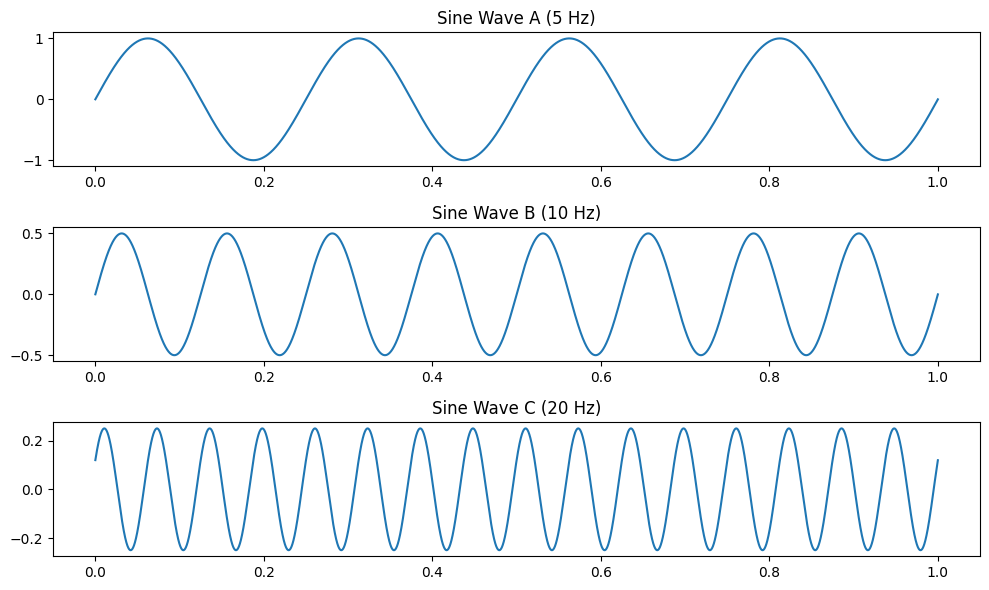

In [18]:
sampling_rate = 48000
T = 1.0
n_samples = int(T * sampling_rate)
time = np.linspace(0.0, T, n_samples, endpoint=False)

# the first sine wave has a frequency of 4 Hz and an amplitude of 1.0
sine_wave_A = 1.0 * np.sin(2.0 * np.pi * 4.0 * time)
# the second sine wave has a frequency of 8 Hz and an amplitude of 0.5
sine_wave_B = 0.5 * np.sin(2.0 * np.pi * 8.0 * time)
# the third sine wave has a frequency of 16 Hz and an amplitude of 0.25
sine_wave_C = 0.25 * np.sin(2.0 * np.pi * 16.0 * time + 0.5)

# plot each sine wave
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(time, sine_wave_A)
plt.title('Sine Wave A (5 Hz)')
plt.subplot(3, 1, 2)
plt.plot(time, sine_wave_B)
plt.title('Sine Wave B (10 Hz)')
plt.subplot(3, 1, 3)
plt.plot(time, sine_wave_C)
plt.title('Sine Wave C (20 Hz)')
plt.tight_layout()


We then combine these sine waves to create a composite signal.

Text(0, 0.5, 'Amplitude')

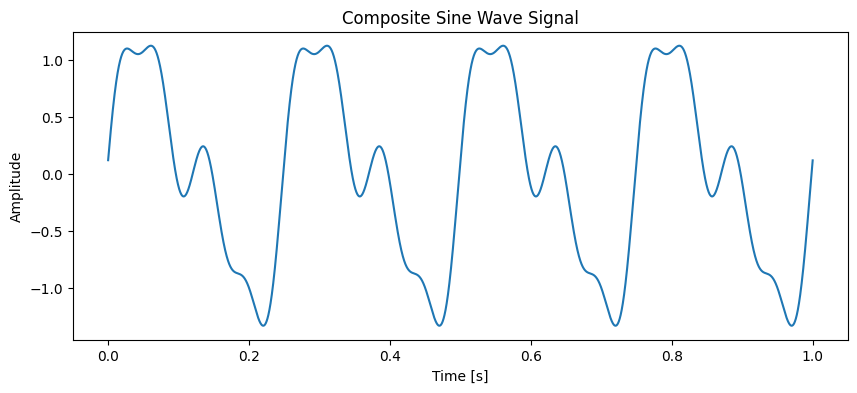

In [19]:
sine_wave_composite = sine_wave_A + sine_wave_B + sine_wave_C

plt.figure(figsize=(10, 4))
plt.plot(time, sine_wave_composite)
plt.title('Composite Sine Wave Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

We then use the **Fast Fourier Transform** (FFT) to decompose the composite signal into its frequency components and visualize the results.

Discrete Fourier Transforms (DFT) are the precursor functions to Fast Fourier Transforms (FFT). In simple terms, the DFT works by correlating the input signal against a set of sine and cosine waves of increasing frequencies (from 0 Hz up to the Nyquist frequency, which is half the sampling rate). The result is a set of numbers that represent the amplitude and phase of each frequency component in the original signal. The downside of the DFT is that it is computationally expensive, especially for large datasets, as it requires O(N^2) operations to compute the transform for N data points.

The FFT algorithm optimizes this process by reducing the number of calculations needed, making it much faster for large datasets. It does this by breaking down the DFT into smaller DFTs, exploiting symmetries and redundancies in the calculations. The FFT reduces the computational complexity to O(N log N), which is a significant improvement over the DFT for large N.

In [20]:
def fft_analysis(signal, sampling_rate):
    """
    Perform FFT analysis on a given signal and extract frequency components from the 
    signal.
    
    Parameters:
    signal (array-like): The input time-domain signal.
    sampling_rate (float): The sampling rate of the signal in Hz.
    
    Returns:
    dict: A dictionary containing frequency components and their corresponding magnitudes.
    """
    
    fft_values = np.fft.fft(signal)
    n_samples = len(signal)

    freqs = np.fft.fftfreq(n_samples, d=1/sampling_rate)
    magnitude = np.abs(fft_values)

    positive_freqs = freqs[:n_samples//2]
    positive_magnitude = magnitude[:n_samples//2]

    return {
        'frequencies': positive_freqs,
        'magnitude': positive_magnitude
    }

Note that the number of bins produced by the FFT is equal to the length of the input signal. However, the FFT output is symmetric, so we only need to consider the first half of the output for real-valued signals.

The graph produced by a FFT is called a **frequency spectrum**. The x-axis represents the different frequency components present in the signal, while the y-axis represents the amplitude (or magnitude) of each frequency component. Peaks in the frequency spectrum indicate the presence of specific frequencies in the original signal, with higher peaks corresponding to stronger contributions from those frequencies.

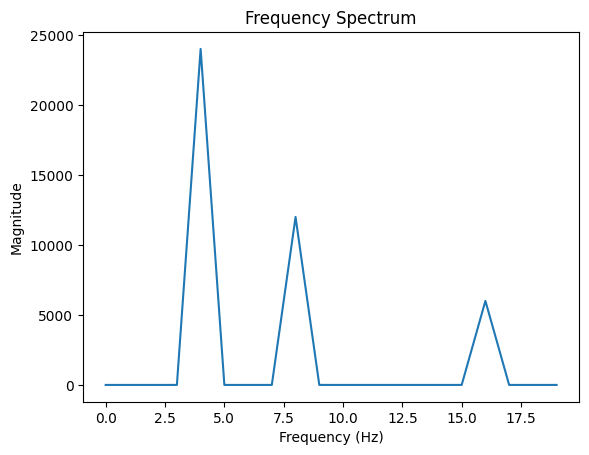

In [24]:
fft_results = fft_analysis(sine_wave_composite, sampling_rate)

plt.figure()
plt.plot(fft_results['frequencies'][:20], fft_results['magnitude'][:20])
plt.title("Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

We can see that the FFT finds the three frequencies (4hz, 8hz, 16hz) that we used to build the composite signal in a very clean and organized way.

As the frequency with the highest magnitude, we can see that the 4 Hz component is the **dominant frequency** in this composite signal.

Let's apply this to the bearing dataset to identify it's dominant frequencies.

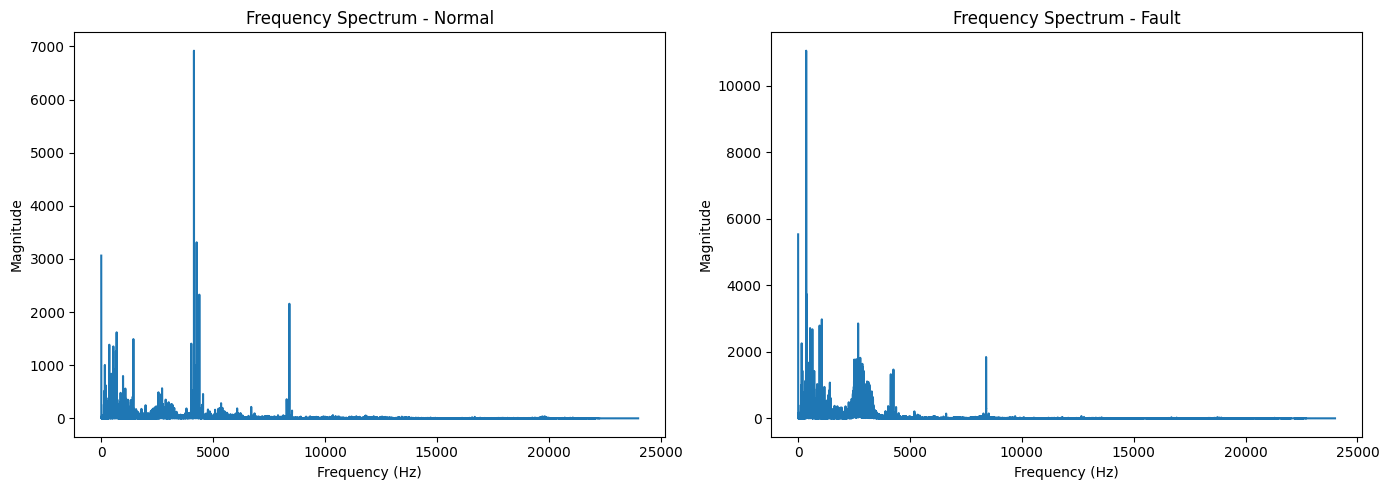

In [ ]:
normal_fft_results = fft_analysis(ts_normal, sampling_rate=48000)
fault_fft_results = fft_analysis(ts_fault, sampling_rate=48000)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(normal_fft_results['frequencies'], normal_fft_results['magnitude'])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Spectrum - Normal")
plt.subplot(1, 2, 2)
plt.plot(fault_fft_results['frequencies'], fault_fft_results['magnitude'])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Spectrum - Fault")
plt.tight_layout()
plt.show()

There are a lot more contributing frequencies in the bearing data, indicating a more complex signal composition as might be expected from real-world sensor data.

Next, we will create a spectogram. A **spectrogram** is a visual representation of the spectrum of frequencies in a signal as it varies with time, essentially many FFTs computed over short, *overlapping* time windows.

I am going to concatenate the normal and fault signals here to create a longer signal to analyze and compare the two states side by side.

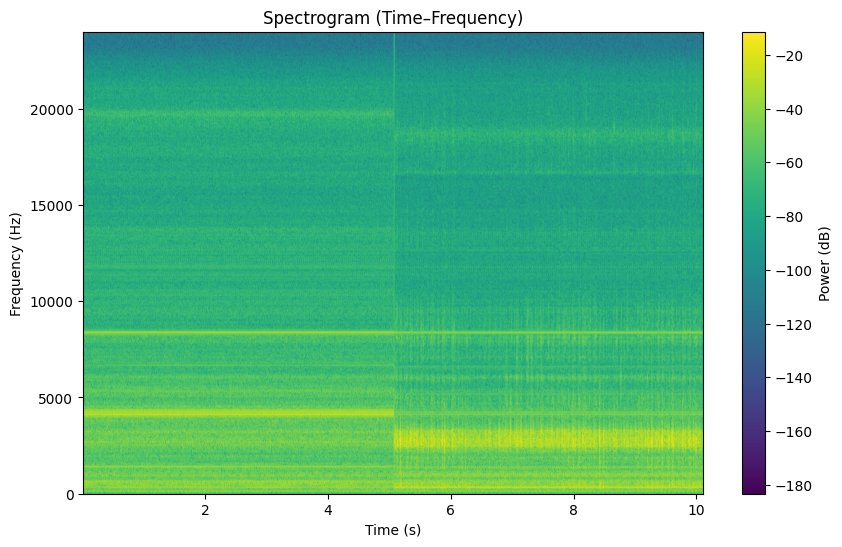

In [28]:
from scipy.signal import spectrogram

f, t_spec, Sxx = spectrogram(
    np.concatenate([ts_normal, ts_fault[len(ts_normal):]]),
    fs=48000,
    window="hann",
    nperseg=1024, 
    noverlap=512,
    scaling="spectrum"
)

plt.figure(figsize=(10,6))
plt.pcolormesh(t_spec, f, 10*np.log10(Sxx), shading="gouraud")
plt.colorbar(label="Power (dB)")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.title("Spectrogram (Time–Frequency)")
plt.ylim(0, 48000/2)
plt.show()

We can see the difference in the signal between the normal and faulty bearing data very clearly when they are concatenated together. The dominant frequencies and their amplitudes change significantly when the fault occurs.

Spectograms are useful for visualizing how the frequency content of a signal changes over time, which can be particularly important for detecting transient events or anomalies in the data. In machine learning applications, features derived from the spectogram (e.g., dominant frequencies, energy in specific frequency bands) can be used as inputs to models for tasks such as anomaly detection or predictive maintenance.

# Convolutions and Filtering

Convolutions are any operation that combines a signal with a function to produce a third signal. Moving averages are a simple example of a convolution, where the input signal is combined with a kernel (the moving average window) to produce a smoothed output signal. For illustrative purposes, we will use an edge detection kernel to demonstrate how convolutions work.

The edge detection kernel is [-1, 0, 1]. The zero in the middle means that the current value does not contribute to the output. The -1 and 1 on either side mean that the output will be the difference between the next value and the previous value. When flat, the output will be zero, but when there is a change in the signal, the output will be non-zero, indicating an edge. In practice, convolution flips the impulse response because it models how a system reacts to an impulse that happened in the past and continues affecting the future.



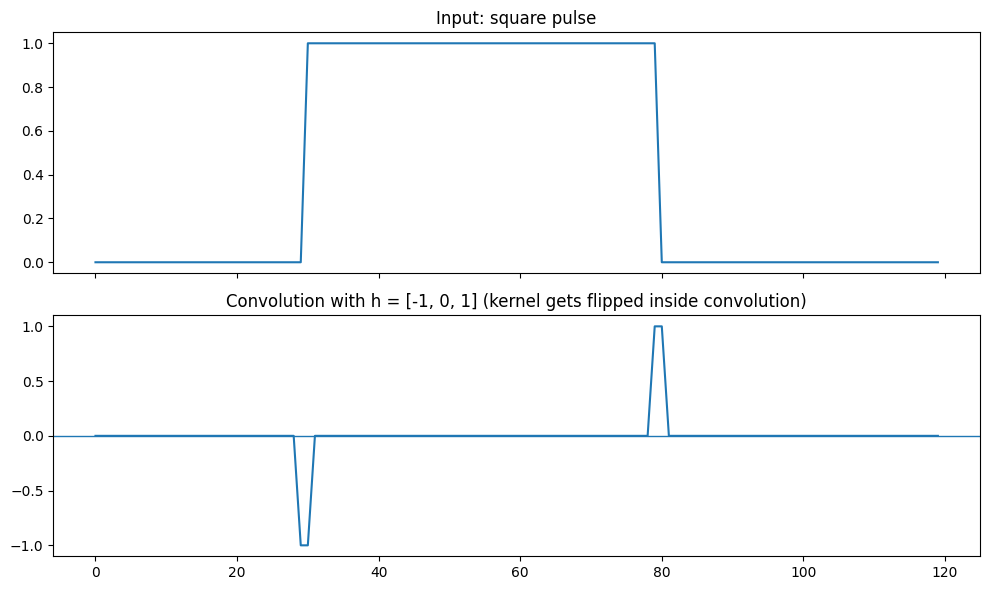

In [12]:
# simple square pulse signal
N = 120
x = np.zeros(N)
x[30:80] = 1.0 

# edge detection kernel h
h = np.array([-1.0, 0.0, 1.0])
h_flipped = h[::-1]

# apply convolution
y_conv = np.convolve(x, h, mode="same")

# --- 4) Plot ---
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axes[0].plot(x)
axes[0].set_title("Input: square pulse")

axes[1].plot(y_conv)
axes[1].axhline(0, linewidth=1)
axes[1].set_title("Convolution with h = [-1, 0, 1] (kernel gets flipped inside convolution)")

plt.tight_layout()
plt.show()


# Wavelet Transform

Wavelet transforms are another powerful tool for analyzing signals, particularly when dealing with non-stationary data where frequency components may change over time. Unlike the Fourier Transform, which provides a global frequency representation of the signal, wavelet transforms offer a time-frequency representation, allowing us to analyze how different frequency components evolve over time.

Wavelet transforms work by decomposing a signal into a set of basis functions called wavelets, which are localized in both time and frequency. This localization allows wavelet transforms to capture transient features and abrupt changes in the signal more effectively than Fourier-based methods.